# Initialisation

In [3]:
from PyLQR.sim import KDLRobot
from PyLQR.system import PosOrnPlannerSys, PosOrnKeypoint
from PyLQR.solver import BatchILQRCP, BatchILQR, ILQRRecursive
from PyLQR.utils import primitives, PythonCallbackMessage

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D # <--- This is important for 3d plotting 
import cv2
import matplotlib.cm as cm
from tqdm import tqdm

import logging
import sys

from scipy.spatial.transform import Rotation 

from contact_grasp.srv import *
from cv_bridge import CvBridge, CvBridgeError

sys.path.append("/home/vdrame/catkin_ws/src/py_panda/PyPanda")
from PyPanda import Robot
import rospy
from PyPanda import Utils

from utils.camera_utils import RealCamera, RealCameraROS
from utils.transform_utils import *
from utils.iLQR_wrapper import iLQR
from utils.visualisation_utils import depth2pc

import argparse
from scipy.spatial.transform import Rotation

import time

from sensor_msgs.msg import Image, PointCloud2

import rospy
from contact_grasp.srv import contactGraspnetPointcloud2, contactGraspnetPointcloud2Response
# from contact_grasp.transform_utils import pose_inv

import json
from cv_bridge import CvBridge, CvBridgeError
from sensor_msgs import point_cloud2
from sensor_msgs.msg import PointField, CameraInfo
from std_msgs.msg import Header

import open3d as o3d

/home/vdrame/miniconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/vdrame/miniconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/vdrame/miniconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


ModuleNotFoundError: No module named 'CvBridge'

In [9]:
def run_action(rbt, actions, control_freq, eef_pos=None, eef_quat=None, segmentation_type=None, show_agentview=False, object_range=[5,8]):
    success = False
    rate = rospy.Rate(int(control_freq))

    for idx, action in tqdm(enumerate(actions)):
        rbt.active_controller.send_command(action)
        rate.sleep()
        #env.sim.step()
        if eef_pos is not None:
            eef_pos.append(rbt.model.ee_pos_rel())
        if eef_quat is not None:
            eef_quat.append(rbt.model.ee_orn_rel())
    success = True
    return success, idx, eef_pos, eef_quat

def generate_grasps_client(pc2, bgr8):
    rospy.wait_for_service('generate_grasps_pc')
    try:
        print("calling service")
        generate_grasps = rospy.ServiceProxy('generate_grasps_pc', contactGraspnetPointcloud2)
        resp1 = generate_grasps(pc2, bgr8)
        return resp1.quat, resp1.pos, resp1.opening.data, resp1.score.data, resp1.detected.data, resp1.detected_with_collision.data
    except rospy.ServiceException as e:
        print("Service call failed: %s"%e)

def format_pointcloud_msg(points, colors):
    points = np.hstack((points, colors)).astype(dtype=object)
    points[:,3:] = points[:,3:].astype(np.uint8)
    fields = [PointField('x', 0, PointField.FLOAT32, 1),
          PointField('y', 4, PointField.FLOAT32, 1),
          PointField('z', 8, PointField.FLOAT32, 1),
          # PointField('rgb', 12, PointField.UINT32, 1),
          PointField('r', 12, PointField.UINT8, 1),
          PointField('g', 13, PointField.UINT8, 1),
          PointField('b', 14, PointField.UINT8, 1),
          ]
    
    header = Header()
    header.frame_id = 'camera_link'
    pc2 = point_cloud2.create_cloud(header, fields, points)
    return pc2

In [11]:
def get_camera_pose(rbt):
    """ Get camera pose in robot base frame
    """
    ee_pose = np.eye(4)
    ee_pose[:3,:3] = quat2mat(convert_quat(rbt.model.ee_orn_rel(), to="xyzw")) #xyzw
    ee_pose[:3,3] = rbt.model.ee_pos_rel() 

    ee2hand = np.eye(4)
    ee2hand[2,3] = -0.1034

    with open('config/camera_calibration.json') as json_file:
        camera_calibration = json.load(json_file)

    camera_type = "L515" #D415 or L515

    hand2camera_pos = np.array(camera_calibration[camera_type]["pos"])
    hand2camera_quat = camera_calibration[camera_type]["quat_xyzw"] #xyzw

    # TODO todelete
    # #D415
    # # hand2camera_pos = np.array([0.0488546636437146,-0.03384417860749521,0.0512776975002817]) 
    # # hand2camera_quat = [0.012961267509189803,-0.0012768531849757236,0.7052247395136084,0.708864191484139] #xyzw 

    # #L515
    # hand2camera_pos = np.array([0.08329189218278059, 0.0014213145240625528, 0.0504764049956106]) 
    # hand2camera_quat = [0.01521805627198811, 0.00623363612254646, 0.712108725756912, 0.7018765669580811] #xyzw 

    hand2camera_mat = Rotation.from_quat(hand2camera_quat).as_matrix()

    hand2camera = np.eye(4)
    hand2camera[:3,:3] = hand2camera_mat
    hand2camera[:3,3] = hand2camera_pos

    current_pose = ee_pose @ ee2hand @ hand2camera

    return current_pose

In [15]:
bridge = CvBridge()
rospy.init_node("python_node",anonymous=True)

dispose_pos = np.array([0.1, 0.66, 0.1])
dispose_orn_wxyz = np.array([0, 1, 0.35, 0])

# Load robot
rbt = Robot("panda", use_gripper=True)
rbt.gripper.homing()

camera_connexion = "ROS"
if camera_connexion == "ROS":
    camera = RealCameraROS()
    intrinsic, distortion = camera.getIntrinsic()
elif camera_connexion == "pyWrapper":
    camera = RealCamera()
    camera.start()
    #retrieve image and depth
    for i in range(15):
        rgb, depth_image, depth_scale = camera.get_rgb_depth()

    rgb, depth_image, depth_scale = camera.get_rgb_depth()
    intrinsic, distortion = camera.getIntrinsic()
else:
    raise Exception("Please choose a valid camera connexion method: ROS or pyWrapper")

[WARN] [1685118792.050808]: No controllers are running


True

# PC init

In [59]:
print("rbt end effector pos:", rbt.model.ee_pos_rel())
print("rbt end effector quat (wxyz):", rbt.model.ee_orn_rel())
print("eef rot",  Rotation.from_quat(convert_quat(rbt.model.ee_orn_rel(), to="xyzw")).as_euler("xyz", degrees=True))
print("--------------------------------------------------------------------------")

reference_pose = get_camera_pose(rbt)

img_init, depth_image, depth_scale = camera.get_rgb_depth()
depth_init = depth_image * depth_scale

pc = None
pc_colors = None
pc_init, pc_colors_init = depth2pc(depth_init, intrinsic, img_init)
pc2_msg = format_pointcloud_msg(pc_init.copy(), pc_colors_init.copy())
bgr_msg = bridge.cv2_to_imgmsg(img_init, encoding="bgr8")

init_pos = rbt.model.ee_pos_rel()
init_orn_wxyz = rbt.model.ee_orn_rel()

# view_init_pos = [0.17908377, 0.23450877, 0.44783125]
# view_init_orn_wxyz = [0.0030477, 0.92571715, 0.37800879, 0.01215875]
# view_front_pos = [0.36072976, 0.41291873, 0.30648647]
# view_front_orn_wxyz = [ 0.1655683,   0.81494402,  0.28065989, -0.47925298]
# view_right_pos = [0.10118165, 0.47394513, 0.30265239]
# view_right_orn_wxyz = [ 0.3190109,   0.94507174, -0.07051679,  0.00994117]
# view_back_pos = [0.00465632, 0.32838561, 0.26232907]
# view_back_orn_wxyz = [ 0.06700862,  0.96685827, -0.02494526,  0.24509727]

# view_pose = [get_camera_pose(rbt)]
# views_pos = [init_pos, view_front_pos, view_right_pos, view_back_pos]
# views_orn_wxyz = [init_orn_wxyz, view_front_orn_wxyz, view_right_orn_wxyz, view_back_orn_wxyz]

#load pos and orn from json file
with open('config/views_pos.json') as json_file:
    views_pos = json.load(json_file)

keys = views_pos.keys()
for key in keys:
    print(views_pos[key]["pos"])
    print(views_pos[key]["orn_wxyz"])    

rbt end effector pos: [0.18830081 0.2428148  0.45746247]
rbt end effector quat (wxyz): [ 0.02038033  0.92140273  0.38786813 -0.0126478 ]
eef rot [178.40887098   2.24182246  45.62657023]
--------------------------------------------------------------------------


# Grasping

In [60]:
eef_pos, eef_quat = [], []
traj_gen = iLQR(rbt)
rbt.stop_controller()
rbt.error_recovery()
rbt.switch_controller("joint_velocity_controller")
rbt.active_controller
#Ros CV bridge to convert data from opencv to ROSImage

# Call to the server
orn, pos, opening, score, detected, detected_with_collision = generate_grasps_client(pc2_msg, bgr_msg)
if (detected or detected_with_collision) and opening>0.03:
    grasp_pos_world, grasps_orn_world_xyzw = poseCam2World(pos, orn, reference_pose)
    grasp_orn_world_wxyz =  convert_quat(grasps_orn_world_xyzw, to="wxyz")

    print("--------------------------------------------------------------------------")
    print("\n\ngrasps in world frame :\n pos :", grasp_pos_world, "\n grasps_orn_world :", grasps_orn_world_xyzw, "\ngrasp world rot",  Rotation.from_quat(grasps_orn_world_xyzw).as_euler("xyz", degrees=True))
    print("--------------------------------------------------------------------------")
else:
    pc_fused = pc_init
    pc_colors_fused = pc_colors_init
    pos_dif = 1000
    for key in keys:
    # while (not detected or not detected_with_collision):
        horizon = 30
        while pos_dif > 0.01:
            view_jpos, view_x_pos, view_U, view_Ks, view_ds, pos_dif, orn_dif = traj_gen.direct_trajectory(rbt.q, rbt.dq, views_pos[key]["pos"], views_pos[key]["orn_wxyz"], horizon)
            horizon *= 2

        view_U = np.array(view_U)
        success, idx, eef_pos, eef_quat = run_action(rbt, view_U, 20)
        rbt.active_controller.send_command(np.zeros(7))
        
        img_cv, depth_cv, depth_scale = camera.get_rgb_depth()
        depth_cv = depth_cv * depth_scale

        current_pose = get_camera_pose(rbt)

        pc_fused, pc_colors_fused = add_view2pc(pc_fused, pc_colors_fused, reference_pose, current_pose, new_gbr=img_cv, 
                                                new_depth=depth_cv, cam_intrisic=intrinsic, regularize=True, voxel_size=0.003)
        pc2_msg = format_pointcloud_msg(pc_fused, pc_colors_fused)
        bgr_msg = bridge.cv2_to_imgmsg(img_init, encoding="bgr8")

        orn, pos, opening, score, detected, detected_with_collision = generate_grasps_client(pc2_msg, bgr_msg)

        print("detected :", detected)
        if (detected or detected_with_collision) and opening > 0.03:
            grasp_pos_world, grasps_orn_world_xyzw = poseCam2World(pos, orn, reference_pose)
            grasp_orn_world_wxyz = convert_quat(grasps_orn_world_xyzw, to="wxyz")

            print("--------------------------------------------------------------------------")
            print("\n\ngrasps in world frame :\n pos :", grasp_pos_world, "\n grasps_orn_world :", grasps_orn_world_xyzw, "\ngrasp world rot",  Rotation.from_quat(grasps_orn_world_xyzw).as_euler("xyz", degrees=True))
            print("------------------------------------ --------------------------------------")
            
            break
        # break

difference between iLQR model ee and real robot ee
quat (zyzw) :[-4.296831e-06 -9.962450e-07 -9.567962e-08  1.000000e+00]
pos:[ 1.27757439e-06 -3.96351740e-07 -4.81387367e-07]


[WARN] [1685120933.189487]: No controllers are running


calling service
--------------------------------------------------------------------------


grasps in world frame :
 pos : [0.32536449 0.3265709  0.06706318] 
 grasps_orn_world : [ 0.81111807  0.5272959  -0.11863372  0.22354557] 
grasp world rot [164.76073837  25.35345764  62.60747773]
--------------------------------------------------------------------------


# trajectory

Iteration 1, Cost: 0.113959, alpha= 1.000000

Iteration 2, Cost: 0.113752, alpha= 0.062500

Iteration 3, Cost: 0.101702, alpha= 0.125000

Iteration 4, Cost: 0.085405, alpha= 0.250000

Iteration 5, Cost: 0.025873, alpha= 1.000000

Iteration 6, Cost: 0.024790, alpha= 0.062500

Iteration 7, Cost: 0.023003, alpha= 0.125000

Iteration 8, Cost: 0.022016, alpha= 0.125000

Iteration 9, Cost: 0.019447, alpha= 0.125000

Iteration 10, Cost: 0.015887, alpha= 0.250000

Iteration 11, Cost: 0.009318, alpha= 0.500000

Iteration 12, Cost: 0.006803, alpha= 1.000000

Iteration 13, Cost: 0.006443, alpha= 0.062500

Iteration 14, Cost: 0.006066, alpha= 0.062500

Iteration 15, Cost: 0.006051, alpha= 0.125000

Iteration 16, Cost: 0.005891, alpha= 0.125000

Iteration 17, Cost: 0.005679, alpha= 0.125000

Iteration 18, Cost: 0.005461, alpha= 0.125000

Iteration 19, Cost: 0.005237, alpha= 0.125000

Iteration 20, Cost: 0.004974, alpha= 0.125000

Iteration 21, Cost: 0.004626, alpha= 0.125000

Iteration 22, Cost: 0.

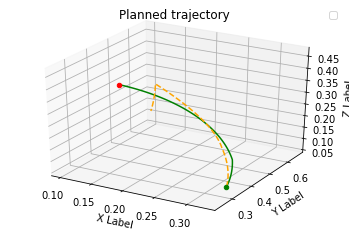

In [61]:
grasp_horizon = 60
grasp_jpos, grasp_x_pos, grasp_U, grasp_Ks, grasp_ds, pos_dif, orn_dif = traj_gen.grasping_trajectory(rbt.q, rbt.dq, grasp_pos_world, grasp_orn_world_wxyz, grasp_horizon)

grasp_q = grasp_jpos[-1]
grasp_dq = np.zeros_like(grasp_q)
dispose_jpos, dispose_x_pos, dispose_U, dispose_Ks, dispose_ds, pos_dif, orn_dif = traj_gen.dispose_trajectory(grasp_q, grasp_dq, grasp_pos_world, grasp_orn_world_wxyz, dispose_pos, dispose_orn_wxyz, 120)
iLQR.plot_trajectory(init_pos, grasp_pos_world, grasp_x_pos, dispose_x_pos)


In [62]:
rbt.stop_controller()
rbt.error_recovery()
rbt.switch_controller("joint_velocity_controller")
rbt.active_controller

[WARN] [1685120998.595695]: No controllers are running


In [63]:
rbt.gripper.move(width=opening + 0.015)

True

In [64]:
grasp_U = np.array(grasp_U)
success, idx, eef_pos, eef_quat = run_action(rbt, grasp_U[:-30], 20)
rbt.active_controller.send_command(np.zeros(7))
time.sleep(1)
success, idx, eef_pos, eef_quat = run_action(rbt, grasp_U[-30:], 20)
rbt.active_controller.send_command(np.zeros(7))
rbt.gripper.move(width=opening-0.015)

# print("rbt end effector pos:", rbt.model.ee_pos_rel())
# print("rbt end effector quat (wxyz):", rbt.model.ee_orn_rel())
# print("eef rot",  Rotation.from_quat(rbt.model.ee_orn_rel()).as_euler("xyz", degrees=True))
# print("--------------------------------------------------------------------------")
# print("\n\ngrasps in world frame :\n pos :", grasp_pos_world, "\n grasps_orn_world :", grasps_orn_world_xyzw, "\ngrasp world rot",  Rotation.from_quat(grasps_orn_world_xyzw).as_euler("xyz", degrees=True))
# print("--------------------------------------------------------------------------")
# print("\n\ILQR final pose in world frame :\n pos :", grasp_x_pos[-1][:3], "\n grasps_orn_world wxyz:", convert_quat(grasp_x_pos[-1][3:], to="xyzw"), "\ngrasp world rot",  Rotation.from_quat(convert_quat(grasp_x_pos[-1][3:], to="xyzw")).as_euler("xyz", degrees=True))

80it [00:03, 20.01it/s]
39it [00:01, 19.99it/s]


False

In [65]:
dispose_U = np.array(dispose_U)
success, idx, eef_pos, eef_quat = run_action(rbt, dispose_U, 20)
rbt.active_controller.send_command(np.zeros(7))
rbt.gripper.move(width=0.07)


119it [00:05, 20.01it/s]


False

In [66]:
rbt.gripper.homing()

True

In [67]:
return_horizon = 60
return_jpos, return_x_pos, return_U, return_Ks, return_ds, pos_dif, orn_dif = traj_gen.direct_trajectory(rbt.q, rbt.dq, init_pos, init_orn_wxyz, return_horizon)
return_U = np.array(return_U)
success, idx, eef_pos, eef_quat = run_action(rbt, return_U, 20)
rbt.active_controller.send_command(np.zeros(7))

Iteration 1, Cost: 0.071008, alpha= 0.500000

Iteration 2, Cost: 0.044349, alpha= 1.000000

Iteration 3, Cost: 0.005574, alpha= 1.000000

Iteration 4, Cost: 0.000013, alpha= 1.000000

Iteration 5, Cost: 0.000001, alpha= 1.000000

Iteration 6, Cost: 0.000001, alpha= 1.000000

Iteration 7, Cost: 0.000001, alpha= 0.000977



119it [00:05, 20.00it/s]


In [ ]:
rbt.stop_controller()

# Miscellaneous

## Get end effector pos

In [ ]:
print("rbt end effector pos:", rbt.model.ee_pos_rel())
print("rbt end effector quat (wxyz):", rbt.model.ee_orn_rel())
print("eef rot",  Rotation.from_quat(convert_quat(rbt.model.ee_orn_rel(), to="xyzw")).as_euler("xyz", degrees=True))


## Show pc with open3d

In [ ]:
import open3d as o3d
pc_o3d = o3d.geometry.PointCloud()
pc_o3d.points = o3d.utility.Vector3dVector(pc_init)
pc_o3d.colors = o3d.utility.Vector3dVector(pc_colors_init/255)
coordinate = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.1)
coordinate.translate([0,0 , 0.4])
o3d.visualization.draw_geometries([coordinate, pc_o3d])


# TODEL

## moved to transform utils

In [ ]:
# def regularize_pc(pc, pc_colors, method="Voxel", n_points=10000, voxel_size=0.005):
#     """ Regularize point cloud by either voxel downsampling or random sampling"""
#     if method == "voxel":
#         pcd = o3d.geometry.PointCloud()
#         pcd.points = o3d.utility.Vector3dVector(pc)
#         pcd.colors = o3d.utility.Vector3dVector(pc_colors)
#         pcd = pcd.voxel_down_sample(voxel_size=voxel_size)
#         pc = np.asarray(pcd.points)
#         pc_colors = np.asarray(pcd.colors)

#     elif method == "random":
#         if pc.shape[0] > n_points:
#             idx = np.random.choice(pc.shape[0], n_points, replace=False)
#             pc = pc[idx]
#             pc_colors = pc_colors[idx]
#         else:
#             print("Warning: pc has less than {} points".format(n_points))
#     else:
#         print("Error: method {} not implemented, please chose between [voxel, random]".format(method))

#     return pc, pc_colors

# def add_view2pc(pc, pc_colors, main_view_pose, camera_pose, new_pc=None, new_pc_colors=None,
#                 new_gbr=None, new_depth=None, cam_intrisic=None, regularize=True, voxel_size=0.005):
#     """ Add new view to point cloud and fuse it with the previous one,
#         Need either the new point cloud or the new rgb, depth and camera intrinsic to function
     
#     Args:
#         pc (np.array): point cloud of shape (n_points, 3)
#         pc_colors (np.array): point cloud colors of shape (n_points, 3)
#         main_view_pose (np.array): pose of the pc origin
#         camera_pose (np.array): pose of the new view
#         new_pc (np.array): point cloud to fused with pc of shape (n_points, 3)
#         new_pc_colors (np.array): point cloud colors to fused with pc of shape (n_points, 3)
#         new_gbr (np.array): new rgb image of shape (H, W, 3)
#         new_depth (np.array): new depth image of shape (H, W)
#         cam_intrisic (np.array): camera intrinsic matrix of shape (3, 3)
#         regularize (bool): whether to regularize the point cloud
#         voxel_size (float): voxel size for regularization

#     Returns:
#         fused_pc (np.array): fused point cloud of shape (n_points, 3)
#         fused_pc_colors (np.array): fused point cloud colors of shape (n_points, 3)"""
#     if new_pc is None:
#         if new_depth is None or new_gbr is None or cam_intrisic is None:
#             print("Error: (new_pc and new_pc_colors) or (new_depth, new_gbr, cam_intrisic) must be provided")
#             return pc

#         new_pc, new_pc_colors = depth2pc(new_depth, cam_intrisic, new_gbr)

#     new2main = pose_inv(main_view_pose) @ camera_pose
#     new_pc_in_mainView = (new2main[:3, :3] @ new_pc.T).T + new2main[:3,3]

#     if pc is not None:
#         fused_pc = np.vstack((pc, new_pc_in_mainView))
#         fused_pc_colors = np.vstack((pc_colors, new_pc_colors))
#     else:
#         fused_pc = new_pc_in_mainView
#         fused_pc_colors = new_pc_colors

#     if regularize:
#         fused_pc, fused_pc_colors = regularize_pc(fused_pc, fused_pc_colors, method="voxel", voxel_size=voxel_size)

#     return fused_pc, fused_pc_colors


## moved to camera_utils Camera init

In [ ]:
# camera.stop()

In [ ]:
# def get_img_from_ros(camera_info, depth_info):
#     bridge = CvBridge()
#     img_data = rospy.wait_for_message("/camera/color/image_raw", Image, timeout=0.5)
#     cv_image = bridge.imgmsg_to_cv2(img_data, "bgr8")

#     if (camera_info.height, camera_info.width) != (depth_info.height, depth_info.width):
#             cv_image = cv2.resize(cv_image, dsize=(depth_info.height, depth_info.width), interpolation=cv2.INTER_AREA)
#     return cv_image

# def get_depth_from_ros():
#     bridge = CvBridge()
#     depth_data = rospy.wait_for_message("/camera/aligned_depth_to_color/image_raw", Image, timeout=0.5)
#     depth_image = bridge.imgmsg_to_cv2(depth_data, "16UC1") * 0.001
#     return depth_image

# def get_pc_from_ros():
#     pointcloud_data = rospy.wait_for_message("/camera/depth/color/points", PointCloud2, timeout=0.5)
#     pc = list(point_cloud2.read_points(pointcloud_data, field_names=("x", "y", "z", "rgb")))
#     pc_xyz = np.array(list(map(lambda x: x[0:3], pc)))
#     pc_rgb = list(map(lambda x: x[3], pc))

#     # Received data has rgba encripted in one 4 octect word, we format all data in "raw" format to unpack them by 1 octet packet
#     raw = struct.pack("f"* len(pc_rgb), *pc_rgb)
#     rgba = np.array(struct.unpack("BBBB" *len(pc_rgb), raw))

#     #reshape to only keep the rgb part
#     pc_rgb = np.reshape(rgba, (-1, 4))[:,:3]

#     return pc_xyz, pc_rgb

In [ ]:
# bridge = CvBridge()
# rospy.init_node("python_node",anonymous=True)

# try: 
#     camera_info = rospy.wait_for_message("/camera/color/camera_info", CameraInfo, timeout=0.5)
#     depth_info = rospy.wait_for_message("/camera/aligned_depth_to_color/camera_info", CameraInfo, timeout=0.5)
#     rgb = get_img_from_ros(camera_info, depth_info)
#     depth = get_depth_from_ros()
#     pc, pc_colors = get_pc_from_ros()
#     intrinsic = np.array(camera_info.K).reshape((3,3))
#     distortion = np.array(camera_info.D)
#     camera_connexion = "ROS"

# except Exception as e:
#     print("No rostopic")
#     camera_connexion = "pyWrapper"
#     # Load camera
#     camera = RealCamera()
#     camera.start()
#     #retrieve image and depth
#     for i in range(15):
#         rgb, depth_image, depth_scale = camera.get_rgb_depth()

#     rgb, depth_image, depth_scale = camera.get_rgb_depth()
#     intrinsic, distortion = camera.getIntrinsic()